# Import libraries

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

import networkx as nx
import pickle as pk
import scipy as sp
import scipy.optimize as op
import ase
import ase.io
import copy

sys.path.insert(0,"../src/")
import graph as gr
import sim
import assign as asn
import draw as dr
import db

# Set constants

In [2]:
elems = ["H", "C", "N", "O", "S"]
nmr_elems = ["H", "C", "N", "O"]

isotope = {"H":"$^1$H", "C":"$^{13}$C", "N":"$^{15}$N", "O":"$^{17}$O"}

cmaps = ["Blues", "Reds", "Greens", "Purples", "Oranges"]

# Max limits for chemical shieldings
lims = {}
lims["H"] = [2., 55.]
lims["C"] = [-175., 315.]
lims["N"] = [-600., 500.]
lims["O"] = [-1320., 500.]

# Standard conversion from shielding to shift
# Fixed slope
convs = {}
convs["fix"] = {}
convs["fix"]["H"] = [-1., 30.96]
convs["fix"]["C"] = [-1., 168.64]
convs["fix"]["N"] = [-1., 185.99]
# Probably not enough points for O!
convs["fix"]["O"] = [-1., 205.08]

# Variable slope
convs["fit"] = {}
convs["fit"]["H"] = [-0.94, 29.31]
convs["fit"]["C"] = [-0.97, 166.37]
convs["fit"]["N"] = [-0.96, 183.82]
# Probably not enough points for O!
convs["fit"]["O"] = [-0.58, 242.03]

# Accuracy of shifts of each element
accs = {}
accs["fix"] = {}
accs["fix"]["H"] = 0.66
accs["fix"]["C"] = 3.34
accs["fix"]["N"] = 9.18
# Probably not enough points for O!
accs["fix"]["O"] = 14.74

accs["fit"] = {}
accs["fit"]["H"] = 0.63
accs["fit"]["C"] = 3.07
accs["fit"]["N"] = 8.52
# Probably not enough points for O!
accs["fit"]["O"] = 1.53

# Depth limits for graphs
max_weight = 6

# Set database and output directories

In [3]:
db_dir = "../../Data/Final_DB/"
fig_root = "../data/"

if not os.path.exists(fig_root):
    os.mkdir(fig_root)

# Set molecule and shifts

In [4]:
name = "thymol"
smiles = "Cc1cc(O)c(cc1)C(C)C"

slope = "fix"

# Exerimental shifts from 10.1039/B821018G [Salager, PCCP 2009]
exp_shifts = {}
exp_shifts["H"] = [0.42, 1.05, 1.45, 3.38, 5.40, 6.19, 7.08, 9.99]
exp_shifts["C"] = [18.7, 23.6, 25.5, 26.1, 116.9, 123.6, 126.3, 131.7, 138.4, 150.2]

# HETCOR peaks from 10.1039/B821018G [Salager, PCCP 2009]
corr_shifts = {}
corr_shifts["C-H"] = [[18.7, 0.42], [23.6, 1.45], [25.5, 3.38],
                      [26.1, 1.05], [116.9, 5.40], [123.6, 6.19], [126.3, 7.08]]

# Split by multiplicity
mult_list = {}
mult_list[0] = "CnoH"
mult_list[1] = "CH"
mult_list[2] = "CH2"
mult_list[3] = "CH3"

# Experimental shifts split by multiplicity
mult_shifts = {}
mult_shifts[0] = [131.7, 138.4, 150.2]
mult_shifts[1] = [25.5, 116.9, 123.6, 126.3]
mult_shifts[2] = []
mult_shifts[3] = [18.7, 23.6, 26.1]

# HETCOR peaks split by multiplicity
mult_corr_shifts = {}
mult_corr_shifts[1] = [[25.5, 3.38], [116.9, 5.40], [123.6, 6.19], [126.3, 7.08]]
mult_corr_shifts[2] = []
mult_corr_shifts[3] = [[18.7, 0.42], [23.6, 1.45], [26.1, 1.05]]

# Exclude the entry of thymol in the database
exclude = ["EDOQIA", "EMIPIA", "IPMEPL", "IYODAD", "JANHAH", "LAVXIQ", "POGNAC", "QQQBFJ", "QQQBFJ01", "ZZZMCA"]

In [5]:
# Generate the XYZ structure and list of shifts from the SMILES string
struct, nei_inds, nei_atoms, envs = gr.get_envs_from_smiles(smiles)

# Create the figure directory
fig_dir = fig_root + name + "/"

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

# Write the conformer created
ase.io.write(fig_dir + "{}.xyz".format(name), struct)

# 2D spectrum simulation

In [6]:
elem = "C"
nei_elem = "H"
N_min = 10

Gs = gr.generate_graphs(elem, envs, nei_inds, nei_atoms, max_weight)

In [7]:
# Fetch the database
all_shifts, all_errs, ws, labels, all_crysts, all_inds = db.fetch_entries(db_dir, elem, envs, Gs, max_weight,
                                                                          N_min=N_min, nei_elem=nei_elem, exclude=exclude)



Graph 1/10 found. w = 5, 147 instances. Time elapsed: 10.90 s
Graph 3/10 found. w = 3, 241 instances. Time elapsed: 27.00 s
Graph 6/10 found. w = 3, 123 instances. Time elapsed: 43.33 s
Graph 7/10 found. w = 4, 14 instances. Time elapsed: 33.39 s
Graph 8/10 found. w = 3, 366 instances. Time elapsed: 4.00 s
Graph 9/10 found. w = 4, 2184 instances. Time elapsed: 27.40 s
Graph 10/10 found. w = 4, 2184 instances. Time elapsed: 0.03 s


In [8]:
# Get multiplicities
mults = {}

for l in labels:
    if "H" in l:
        c = l.split("-")[0]
        count = 0
        for l2 in labels:
            if c + "-" in l2:
                count += 1
        
        mults[l] = count
print(mults)

{'C1-H1': 3, 'C1-H3': 3, 'C1-H2': 3, 'C3-H4': 1, 'C6-H6': 1, 'C7-H7': 1, 'C8-H8': 1, 'C9-H9': 3, 'C9-H10': 3, 'C9-H11': 3, 'C10-H14': 3, 'C10-H12': 3, 'C10-H13': 3}


In [9]:
# Cleanup the distributions
if elem == "H":
    labels, Gs, all_shifts, all_errs, ws, all_crysts, all_inds = sim.cleanup_methyls(labels, Gs, all_shifts, all_errs,
                                                                                     ws, all_crysts, all_inds, nei_inds,
                                                                                     nei_atoms, envs)
elif nei_elem == "H":
    labels, all_shifts, all_errs, ws, all_crysts, all_inds = sim.cleanup_nei_methyls(elem, nei_elem, labels, all_shifts,
                                                                                 all_errs, ws, all_crysts, all_inds, envs)
    
labels, all_shifts, all_errs, ws, all_crysts, all_inds = sim.cleanup_equivalent(labels, all_shifts, all_errs, ws,
                                                                                all_crysts, all_inds)
print(labels)

['C1-H1', 'C3-H4', 'C6-H6', 'C7-H7', 'C8-H8', 'C9-H9/C10-H14']


In [10]:
# Get plotting range
lims = sim.get_lims_2D(all_shifts, all_errs)
print(lims)

[[ 13.2085047  174.55827223]
 [ 21.24473946  34.89501   ]]


In [11]:
# Generate the distributions
x = np.linspace(lims[0][0], lims[0][1], 101)
y = np.linspace(lims[1][0], lims[1][1], 101)

Zs = []
for i, (sh, er) in enumerate(zip(all_shifts, all_errs)):
    X, Y, Z = sim.gausses_2D(x, y, sh[:,0], sh[:,1], er[:,0], er[:,1], norm="max")
    Zs.append(Z)
    print("Distribution {}/{} constructed.".format(i+1, len(labels)))

  0%|          | 0/147 [00:00<?, ?it/s]

Distribution 1/6 constructed.


  0%|          | 0/241 [00:00<?, ?it/s]

Distribution 2/6 constructed.


  0%|          | 0/123 [00:00<?, ?it/s]

Distribution 3/6 constructed.


  0%|          | 0/14 [00:00<?, ?it/s]

Distribution 4/6 constructed.


  0%|          | 0/366 [00:00<?, ?it/s]

Distribution 5/6 constructed.


  0%|          | 0/2184 [00:00<?, ?it/s]

Distribution 6/6 constructed.


In [12]:
# Get the centers of each distribution
centers = asn.get_centers_2D(X, Y, Zs)

for l, c in zip(labels, centers):
    print("Atom {}, maximum at {:.2f}/{:.2f} ppm".format(l, c[0]*convs[slope][elem][0]+convs[slope][elem][1],
                                                         c[1]*convs[slope][nei_elem][0]+convs[slope][nei_elem][1]))

Atom C1-H1, maximum at 16.67/1.39 ppm
Atom C3-H4, maximum at 111.87/6.44 ppm
Atom C6-H6, maximum at 128.00/7.12 ppm
Atom C7-H7, maximum at 128.00/6.99 ppm
Atom C8-H8, maximum at 29.58/3.16 ppm
Atom C9-H9/C10-H14, maximum at 15.06/0.57 ppm


In [13]:
# Plot individual distributions
plt.rcParams.update({"font.size": 14})
n_extend = 8

d_dir = fig_dir + "{}-{}_distribs_N_{}/".format(elem, nei_elem, N_min)
if not os.path.exists(d_dir):
    os.mkdir(d_dir)

for i, (Z, c, w, sh) in enumerate(zip(Zs, centers, ws, all_shifts)):
    
    dr.draw_2D_distribution_and_hist(X, Y, Z, c, sh, convs[slope][elem], convs[slope][nei_elem], w,
                                     f=d_dir + "{}.pdf".format(labels[i].replace("/", "_"), N_min),
                                     xlabel="{} Chemical shift [ppm]".format(isotope[elem]),
                                     ylabel="{} Chemical shift [ppm]".format(isotope[nei_elem]),
                                     lw=2, ext=n_extend, display=False, show_G=True, show_N=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

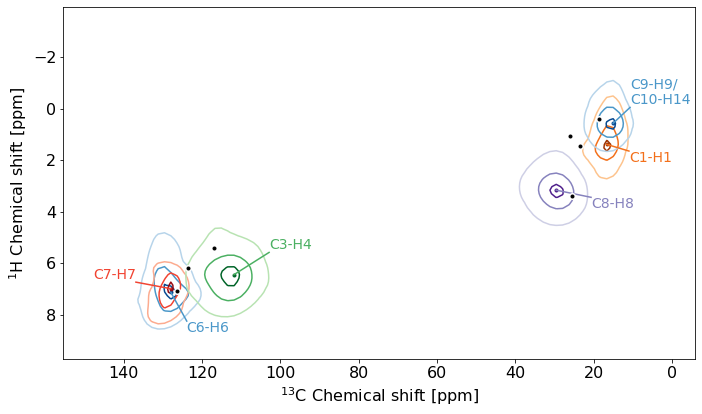

In [14]:
# Plot distributions
plt.rcParams.update({"font.size": 16})

sorted_c_inds = np.argsort(centers[:,0])

dr.draw_2D_distributions(X, Y, [Zs[i] for i in sorted_c_inds], centers[sorted_c_inds], [labels[i] for i in sorted_c_inds],
                         lims, convs[slope][elem], convs[slope][nei_elem], cmaps,
                         exps=np.array(corr_shifts["{}-{}".format(elem, nei_elem)]),
                         xlabel="{} Chemical shift [ppm]".format(isotope[elem]),
                         ylabel="{} Chemical shift [ppm]".format(isotope[nei_elem]),
                         f=fig_dir + "{}-{}_N_{}_distribs.pdf".format(elem, nei_elem, N_min), display=True)

In [15]:
# Get individual assignment scores
scores = asn.compute_scores_2D(corr_shifts["{}-{}".format(elem, nei_elem)], all_shifts, all_errs,
                               convs[slope][elem], convs[slope][nei_elem], centers, Nmax=1e12)
# scores[i, j]: probability of observing shift j given nucleus i
# scores[i]: probability of observing any shift given nucleus i (should be equal to 1)
backup_scores = np.copy(scores)

p_dir = fig_dir + "{}-{}_probs_N_{}/".format(elem, nei_elem, N_min)

if not os.path.exists(p_dir):
    os.mkdir(p_dir)

  0%|          | 0/147 [00:00<?, ?it/s]

Distribution 1/6 computed.


  0%|          | 0/241 [00:00<?, ?it/s]

Distribution 2/6 computed.


  0%|          | 0/123 [00:00<?, ?it/s]

Distribution 3/6 computed.


  0%|          | 0/14 [00:00<?, ?it/s]

Distribution 4/6 computed.


  0%|          | 0/366 [00:00<?, ?it/s]

Distribution 5/6 computed.


  0%|          | 0/2184 [00:00<?, ?it/s]

Distribution 6/6 computed.


            Label     18.70\0.42     23.60\1.45     25.50\3.38     26.10\1.05    116.90\5.40    123.60\6.19    126.30\7.08
            C1-H1         80.00%         19.21%          0.02%          0.77%          0.00%          0.00%          0.00%
            C3-H4          0.00%          0.00%          0.00%          0.00%         61.00%         29.48%          9.52%
            C6-H6          0.00%          0.00%          0.00%          0.00%          0.05%         11.41%         88.54%
            C7-H7          0.00%          0.00%          0.00%          0.00%          0.00%          1.96%         98.04%
            C8-H8          0.08%          3.46%         92.52%          3.94%          0.00%          0.00%          0.00%
    C9-H9/C10-H14         95.38%          3.00%          0.01%          1.60%          0.00%          0.00%          0.00%



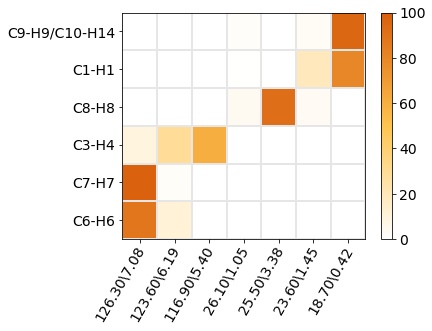

    Label     18.70\0.42     23.60\1.45     25.50\3.38     26.10\1.05    116.90\5.40    123.60\6.19    126.30\7.08
    C1-H1         80.00%         19.21%          0.02%          0.77%          0.00%          0.00%          0.00%
    C3-H4          0.00%          0.00%          0.00%          0.00%         61.00%         29.48%          9.52%
    C6-H6          0.00%          0.00%          0.00%          0.00%          0.05%         11.41%         88.54%
    C7-H7          0.00%          0.00%          0.00%          0.00%          0.00%          1.96%         98.04%
    C8-H8          0.08%          3.46%         92.52%          3.94%          0.00%          0.00%          0.00%

            Label    18.70\0.42/18.70\0.42    18.70\0.42/23.60\1.45    18.70\0.42/25.50\3.38    18.70\0.42/26.10\1.05    23.60\1.45/23.60\1.45    23.60\1.45/26.10\1.05    26.10\1.05/26.10\1.05
    C9-H9/C10-H14                   90.98%                    2.86%                    0.01%                    1.53

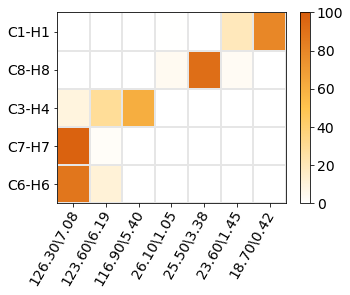

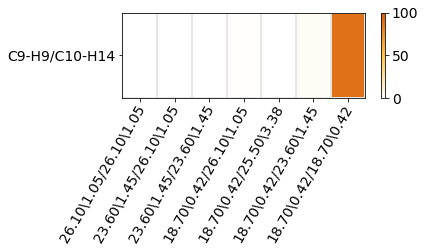

In [16]:
# Get prior probabilities
exp_str = ["{:.2f}\\{:.2f}".format(e[0], e[1]) for e in corr_shifts["{}-{}".format(elem, nei_elem)]]
asn.print_individual_probs(labels, exp_str, scores, p_dir + "prior_probs_{}-{}.dat".format(elem, nei_elem), display=True)

dr.print_probabilities(p_dir + "prior_probs_{}-{}.dat".format(elem, nei_elem))

split_scores = asn.split_scores(scores, labels)
asn.print_split_individual_probs(labels, exp_str, split_scores, p_dir + "split_prior_probs_{}-{}.dat".format(elem, nei_elem), thresh=1e-4, display=True)

dr.print_probabilities(p_dir + "split_prior_probs_{}-{}.dat".format(elem, nei_elem))
    
prior = np.copy(scores)
split_prior = copy.deepcopy(split_scores)

Scores cleaned up, threshold set to 100
Ambiguity found between C1-H1, C9-H9, C10-H14
Corresponding shifts: 18.70\0.42, 23.60\1.45, 26.10\1.05
Mapping 3 nuclei on 3 shifts
Generating all possible assignments...
Rank 0, 1/2, 0 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/2, 0 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 0 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 2/2, 1 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 1 valid assignments so far. Time elapsed: 0.00 s
Rank 0, 2/2, 2 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/2, 2 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 2 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 2/2, 3 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 3 valid assignments so far. Time elapsed: 0.00 s
  4 valid assignments found!
  Computing the scores for the valid assignments...
Done. Time elapsed: 0.01 s
Cleanup equivalent assignments...
2 unique valid 

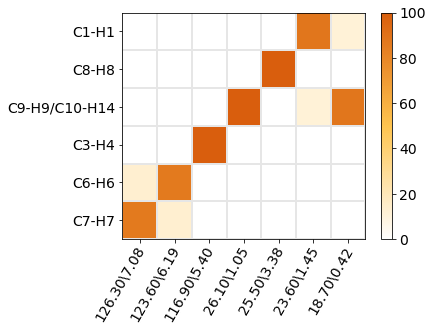

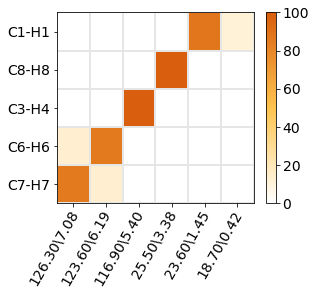

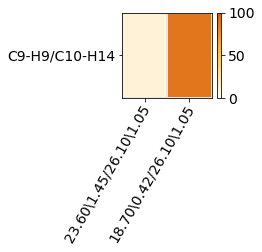

In [17]:
# Generate probabilistic assignments to obtain posterior probabilities

############# Parameters for the probabilistic assignment search ##################

# Threshold for discarding an individual assignment (fraction of the maximum score)
p_thresh = 100
# Maximum number of possible assignments to consider
Nmax = None
# Rank from which only the Nmax most probable assignments are considered
r = 0
# Order of the assignment generation
order = "default"
# Rank up to which progress is displayed
disp_r = 2
# Maximum excess (maximum number of nuclei/distributions assigned to a single shift)
max_excess = 4

###################################################################################

# Get initial possible assignments
scores = np.copy(backup_scores)
possible_assignments, p_thresh = asn.get_possible_assignments(scores, labels, exp_str, thresh=p_thresh, thresh_increase="+1", check_valid=False)


# Store initial possible assignments and matrix of scores
old_possible_assignments = possible_assignments.copy()
old_scores = np.copy(scores)

# Generate all possible assignments
dist_pools, shift_pools, pool_asns, pool_scores, all_labels, equivs = asn.get_probabilistic_assignment(scores, possible_assignments, exp_str, labels, Nmax=Nmax, Nmax_rank=r, order=order, max_excess=max_excess, disp_rank=disp_r)

# Print the valid assignments generated and their probabilities
asn.print_probabilistic_assignment(dist_pools, shift_pools, pool_asns, pool_scores, all_labels, exp_str, equivs,
                                   p_dir + "assignment_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(elem, nei_elem, p_thresh, Nmax, r, order))



# Get the marginal
marginal = asn.update_scores(scores, dist_pools, shift_pools, pool_asns, pool_scores, equivs, labels, all_labels)

split_marginal = asn.update_split_scores(scores, dist_pools, shift_pools, pool_asns, pool_scores, equivs, labels, all_labels)

# Print the marginal
asn.print_individual_probs(labels, exp_str, marginal, p_dir + "marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(elem, nei_elem, p_thresh, Nmax, r, order))

dr.print_probabilities(p_dir + "marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(elem, nei_elem, p_thresh, Nmax, r, order))

asn.print_split_individual_probs(labels, exp_str, split_marginal, p_dir + "split_marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(elem, nei_elem, p_thresh, Nmax, r, order), thresh=1e-4)

dr.print_probabilities(p_dir + "split_marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(elem, nei_elem, p_thresh, Nmax, r, order))

# Split by multiplicity

CH


  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

Atom C3-H4, maximum at 111.87/6.44 ppm
Atom C6-H6, maximum at 128.00/7.12 ppm
Atom C7-H7, maximum at 128.00/6.99 ppm
Atom C8-H8, maximum at 29.58/3.16 ppm


  0%|          | 0/1000 [00:00<?, ?it/s]

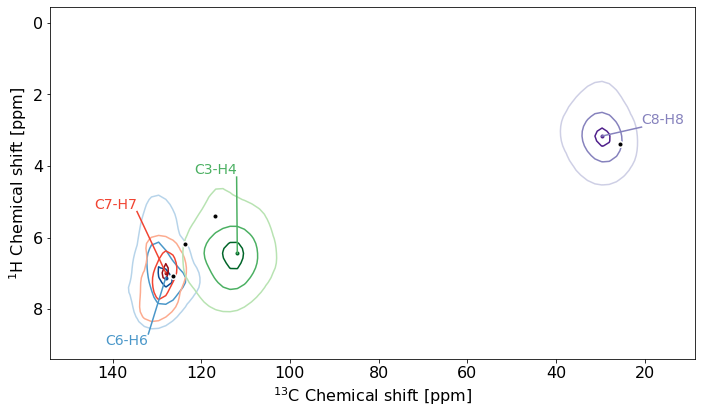

  0%|          | 0/241 [00:00<?, ?it/s]

Distribution 1/4 computed.


  0%|          | 0/123 [00:00<?, ?it/s]

Distribution 2/4 computed.


  0%|          | 0/14 [00:00<?, ?it/s]

Distribution 3/4 computed.


  0%|          | 0/366 [00:00<?, ?it/s]

Distribution 4/4 computed.
    Label     25.50\3.38    116.90\5.40    123.60\6.19    126.30\7.08
    C3-H4          0.00%         61.00%         29.48%          9.52%
    C6-H6          0.00%          0.05%         11.41%         88.54%
    C7-H7          0.00%          0.00%          1.96%         98.04%
    C8-H8        100.00%          0.00%          0.00%          0.00%



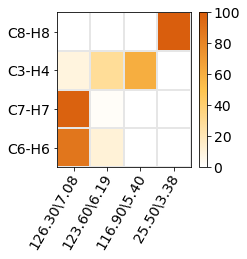

    Label    116.90\5.40    123.60\6.19    126.30\7.08     25.50\3.38
    C3-H4         61.00%         29.48%          9.52%          0.00%
    C6-H6          0.05%         11.41%         88.54%          0.00%
    C7-H7          0.00%          1.96%         98.04%          0.00%
    C8-H8          0.00%          0.00%          0.00%        100.00%




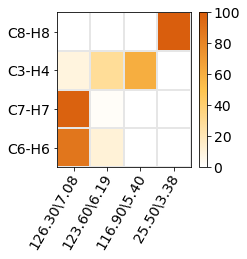

Scores cleaned up, threshold set to 100
Ambiguity found between C3-H4
Corresponding shifts: 116.90\5.40
Mapping 1 nuclei on 1 shifts
Generating all possible assignments...
Rank 0, 1/1, 0 valid assignments so far. Time elapsed: 0.00 s
  1 valid assignments found!
  Computing the scores for the valid assignments...
Done. Time elapsed: 0.00 s
Cleanup equivalent assignments...
1 unique valid assignment extracted from the 1 assignments generated (100.00%). Time elapsed: 0.0002s
Ambiguity found between C6-H6, C7-H7
Corresponding shifts: 123.60\6.19, 126.30\7.08
Mapping 2 nuclei on 2 shifts
Generating all possible assignments...
Rank 0, 1/2, 0 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/1, 0 valid assignments so far. Time elapsed: 0.00 s
Rank 0, 2/2, 1 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/1, 1 valid assignments so far. Time elapsed: 0.00 s
  2 valid assignments found!
  Computing the scores for the valid assignments...
Done. Time elapsed: 0.00 s
Cleanup equi

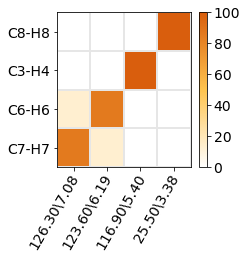

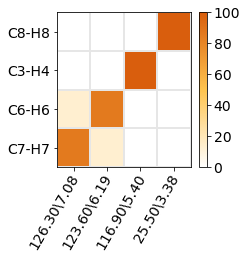

CH3


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/2184 [00:00<?, ?it/s]

Atom C1-H1, maximum at 16.67/1.39 ppm
Atom C9-H9/C10-H14, maximum at 15.06/0.57 ppm


  0%|          | 0/1000 [00:00<?, ?it/s]

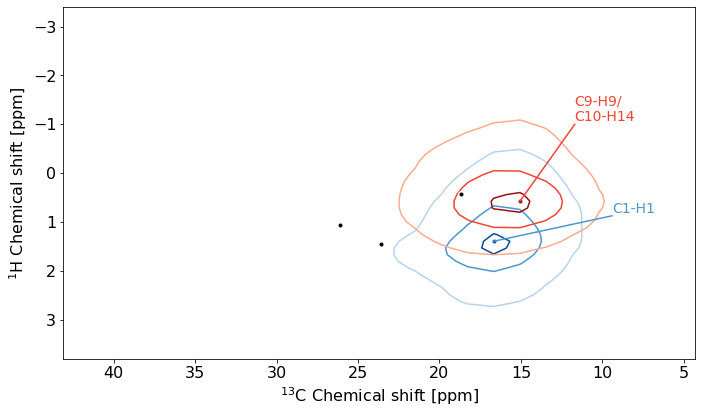

  0%|          | 0/147 [00:00<?, ?it/s]

Distribution 1/2 computed.


  0%|          | 0/2184 [00:00<?, ?it/s]

Distribution 2/2 computed.
            Label    18.70\0.42    23.60\1.45    26.10\1.05
            C1-H1        80.01%        19.22%         0.77%
    C9-H9/C10-H14        95.39%         3.00%         1.60%



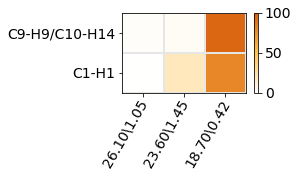

    Label    18.70\0.42    23.60\1.45    26.10\1.05
    C1-H1        80.01%        19.22%         0.77%

            Label    18.70\0.42/18.70\0.42    18.70\0.42/23.60\1.45    18.70\0.42/26.10\1.05    23.60\1.45/23.60\1.45    23.60\1.45/26.10\1.05    26.10\1.05/26.10\1.05
    C9-H9/C10-H14                   91.00%                    2.86%                    1.53%                    0.09%                    0.05%                    0.03%




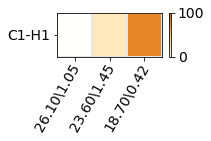

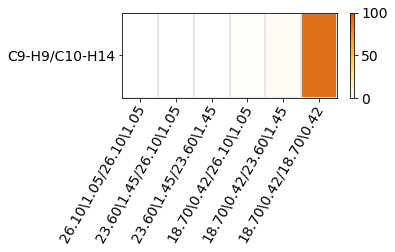

Scores cleaned up, threshold set to 100
Ambiguity found between C1-H1, C9-H9, C10-H14
Corresponding shifts: 18.70\0.42, 23.60\1.45, 26.10\1.05
Mapping 3 nuclei on 3 shifts
Generating all possible assignments...
Rank 0, 1/2, 0 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/2, 0 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 0 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 2/2, 1 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 1 valid assignments so far. Time elapsed: 0.00 s
Rank 0, 2/2, 2 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 1/2, 2 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 2 valid assignments so far. Time elapsed: 0.00 s
 Rank 1, 2/2, 3 valid assignments so far. Time elapsed: 0.00 s
  Rank 2, 1/1, 3 valid assignments so far. Time elapsed: 0.01 s
  4 valid assignments found!
  Computing the scores for the valid assignments...
Done. Time elapsed: 0.01 s
Cleanup equivalent assignments...
2 unique valid 

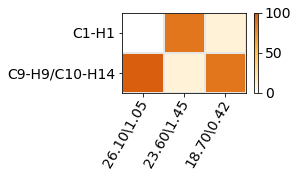

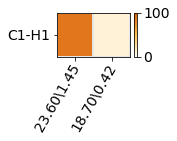

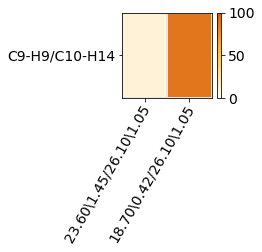

In [18]:
# Generate probabilistic assignments to obtain posterior probabilities

############# Parameters for the probabilistic assignment search ##################

# Threshold for discarding an individual assignment (fraction of the maximum score)
base_p_thresh = 100
# Maximum number of possible assignments to consider
Nmax = None
# Rank from which only the Nmax most probable assignments are considered
r = 0
# Order of the assignment generation
order = "default"
# Rank up to which progress is displayed
disp_r = 2
# Maximum excess (maximum number of nuclei/distributions assigned to a single shift)
max_excess = 4

###################################################################################

# Loop over all multiplicities
for m in range(5):
    scores = np.copy(backup_scores)
    if m in mult_corr_shifts.keys() and len(mult_corr_shifts[m]) > 0:
        print(mult_list[m])
        
        # Get the labels, distributions, shifts, errors and centers of the nuclei that correspond to the current multiplicity
        these_labels = []
        these_Zs = []
        these_shifts = []
        these_errs = []
        these_centers = []
        for l, Z, c, sh, er in zip(labels, Zs, centers, all_shifts, all_errs):
            if mults[l.split("/")[0]] == m:
                these_labels.append(l)
                these_Zs.append(Z)
                these_centers.append(c)
                these_shifts.append(sh)
                these_errs.append(er)
                
        # Get the limits for the selected nuclei
        these_lims = sim.get_lims_2D(these_shifts, these_errs, dx="rms")

        # Get the new distributions Zs
        this_x = np.linspace(lims[0][0], lims[0][1], 101)
        this_y = np.linspace(lims[1][0], lims[1][1], 101)
        these_Zs = []
        for sh, er in zip(these_shifts, these_errs):
            X, Y, Z = sim.gausses_2D(this_x, this_y, sh[:,0], sh[:,1], er[:,0], er[:,1], norm="max", Nmax=int(1e4))
            these_Zs.append(Z)
            
        # Get the new distribution centers
        these_centers = asn.get_centers_2D(X, Y, these_Zs)
        for c, l in zip(these_centers, these_labels):
            print("Atom {}, maximum at {:.2f}/{:.2f} ppm".format(l, c[0]*convs[slope][elem][0]+convs[slope][elem][1],
                                                                 c[1]*convs[slope][nei_elem][0]+convs[slope][nei_elem][1]))
            
        # Plot distributions
        plt.rcParams.update({"font.size": 16})

        sorted_c_inds = np.argsort(these_centers[:,0])

        dr.draw_2D_distributions(X, Y, [these_Zs[i] for i in sorted_c_inds], these_centers[sorted_c_inds], [these_labels[i] for i in sorted_c_inds],
                                 these_lims, convs[slope][elem], convs[slope][nei_elem], cmaps,
                                 exps=np.array(mult_corr_shifts[m]),
                                 xlabel="{} Chemical shift [ppm]".format(isotope[elem]),
                                 ylabel="{} Chemical shift [ppm]".format(isotope[nei_elem]),
                                 f=fig_dir + "{}-{}_N_{}_distribs.pdf".format(mult_list[m], nei_elem, N_min), display=True)
        
        # Get individual assignment scores
        these_scores = asn.compute_scores_2D(mult_corr_shifts[m], these_shifts, these_errs,
                                             convs[slope][elem], convs[slope][nei_elem], these_centers, Nmax=1e12)

        p_dir = fig_dir + "{}-{}_probs_N_{}/".format(elem, nei_elem, N_min)

        if not os.path.exists(p_dir):
            os.mkdir(p_dir)

        p_thresh = base_p_thresh

        # Print prior probabilities
        exp_str = ["{:.2f}\\{:.2f}".format(e[0], e[1]) for e in mult_corr_shifts[m]]
        asn.print_individual_probs(these_labels, exp_str, these_scores, p_dir + "prior_probs_{}-{}.dat".format(mult_list[m], nei_elem), display=True)

        dr.print_probabilities(p_dir + "prior_probs_{}-{}.dat".format(mult_list[m], nei_elem))
        
        split_scores = asn.split_scores(these_scores, these_labels)
        asn.print_split_individual_probs(these_labels, exp_str, split_scores, p_dir + "split_prior_probs_{}-{}.dat".format(mult_list[m], nei_elem), thresh=1e-4, display=True)
        
        dr.print_probabilities(p_dir + "split_prior_probs_{}-{}.dat".format(mult_list[m], nei_elem))
        
        prior = np.copy(these_scores)
        split_prior = copy.deepcopy(split_scores)
        
        possible_assignments, p_thresh = asn.get_possible_assignments(these_scores, these_labels, exp_str, thresh=p_thresh, thresh_increase="+1", check_valid=False)

        # Generate all possible assignments
        dist_pools, shift_pools, pool_asns, pool_scores, all_labels, equivs = asn.get_probabilistic_assignment(these_scores, possible_assignments, exp_str, these_labels, Nmax=Nmax, Nmax_rank=r, order=order, max_excess=max_excess, disp_rank=disp_r)

        # Print the valid assignments generated and their probabilities
        asn.print_probabilistic_assignment(dist_pools, shift_pools, pool_asns, pool_scores, all_labels, exp_str, equivs,
                                           p_dir + "assignment_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(mult_list[m], nei_elem, p_thresh, Nmax, r, order))
        
        # Get the marginal
        marginal = asn.update_scores(these_scores, dist_pools, shift_pools, pool_asns, pool_scores, equivs, these_labels, all_labels)

        split_marginal = asn.update_split_scores(these_scores, dist_pools, shift_pools, pool_asns, pool_scores, equivs, these_labels, all_labels)

        # Print the marginal
        asn.print_individual_probs(these_labels, exp_str, marginal, p_dir + "marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(mult_list[m], nei_elem, p_thresh, Nmax, r, order))

        dr.print_probabilities(p_dir + "marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(mult_list[m], nei_elem, p_thresh, Nmax, r, order))

        asn.print_split_individual_probs(these_labels, exp_str, split_marginal, p_dir + "split_marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(mult_list[m], nei_elem, p_thresh, Nmax, r, order), thresh=1e-4)

        dr.print_probabilities(p_dir + "split_marginal_probs_{}-{}_thresh_{}_Nmax_{}_r_{}_order_{}.dat".format(mult_list[m], nei_elem, p_thresh, Nmax, r, order))